# S&P500 Index Fund Price Forecasting

## Overview

<div style="font-size:large;font-weight:500">Problem</div>
<div style="text-align:justify">Each time economy figures are announced, the market reacts without fail. There is clearly a relationship, but can we nail down this relationship in the form of a statistical model?</div>
<br/>
<div style="font-size:large;font-weight:500">Context</div>
<div style="text-align:justify">
I have always been curious about how a country's economic health affects the prices of certain publicly traded instruments. Hence, investigating for a correlation and finding a predictive model to forecast the prices is naturally one of my first personal studies for public showcase. For this study, I will be investigating if US economic indicators can be used to predict the prices of S&P500 index funds. S&P500 consists of the largest firms in the US, and because the S&P500 index funds aggregate the companies to make up the fund, market-moving news on one firm will have little impact on the fund price. In fact, I am expecting the performance of S&P500 index funds to closely match certain US economic indicators. This is what will be investigated in this notebook.
Two different sets of data are used in this study. Fund prices are downloaded from Yahoo Finance as csv files. It was previously pulled directly from Yahoo via Web API, but Yahoo has since changed their API and I can no longer pull the data from Yahoo without paying a fee.
The US economic indicator data is downloaded from Kaggle. The data is a bit dated (till 2021), but we have sufficient data for analaysis.
<br/>(<i><b>Reference:</b> <a href="https://www.kaggle.com/datasets/calven22/usa-key-macroeconomic-indicators">https://www.kaggle.com/datasets/calven22/usa-key-macroeconomic-indicators</a></i>)</div>
<br/>
<div style="font-size:large;font-weight:500">Objective</div>
<div style="text-align:justify">The objective of this study is to find data model to forecast the price of an S&P500 index fund using US economic indicators as variables.</div>
<br/>

In [342]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
%matplotlib inline

import csv
import requests
import traceback
import yfinance as yf

In [343]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, ElasticNetCV
from sklearn import metrics

from datetime import datetime
from itertools import chain, combinations
from tqdm import tqdm

In [344]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 1000)

In [345]:
'''
Starts timing for performance tracking
---------------------------------------
'''
def start_timing():
    dt_start = datetime.now()
    print("\nStart:", dt_start)
    return dt_start

'''
Prints duration for performance tracking
---------------------------------------
'''
def show_duration(start):
    duration = datetime.now() - start
    print('Duration: {0}'.format(duration))

In [346]:
'''
Loads historic data for economic indicators into a dataframe
-------------------------------------------------------------
[Glossary for loaded economic indicators]
  unrate : Unemployment Rate
     psr : Personal Saving Rate
      m2 : Measure of the money supply that includes cash, checking deposits, and other types of deposits that are readily convertible to cash such as CDs.
   dspic : Real Disposable Personal Income
     pce : Personal Consumption Expenditures
    reer : Real Broad Effective Exchange Rate
      ir : Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity
    ffer : Federal Funds Effective Rate
     tcs : Total Construction Spending
  indpro : Industrial Production Index
    ccpi : Composite Consumer Price Index
'''
def load_econ_data():
    df = pd.read_csv('./data/econ-indicators-mthly.csv', header=0)
    df = df.rename(columns={'DATE': 'date'})
    df["date"] = pd.to_datetime(df.date, format="%Y-%m-%d")
    df.set_index("date", inplace=True, drop=True)
    return df

'''
Loads historic prices for the selected index fund into a dataframe
-------------------------------------------------------------------
[Prepared datasets]
  FNILX : Fidelity ZERO Large Cap Index
    VOO : Vanguard S&P 500 ETF
    SPY : SPDR S&P 500 ETF Trust
    IVV : iShares Core S&P 500 ETF
  SWPPX : Schwab S&P 500 Index Fund
'''
def load_fund_price(symbol):
    df = pd.read_csv('./data/hist_close_{0}.csv'.format(symbol.upper()), header=0)
    df = df.rename(columns={"Date": "date", "Close": "close"})
    df = df[["date","close"]]
    df["date"] = pd.to_datetime(df.date, format="%Y-%m-%d")
    df.set_index("date", inplace=True, drop=True)
    return df

'''
Joins the fund closing price dataset with economic indicators and returns result as dataframe
----------------------------------------------------------------------------------------------
'''
def fetch_joined_data(symbol):
    df_fund = load_fund_price(symbol)
    df_fund = df_fund.reset_index()
    df_fund = df_fund.groupby(pd.Grouper(key='date', freq='MS')).agg({'date': 'first', 'close': 'first'})
    df_fund = df_fund.drop("date", axis=1)    
    df_econ = load_econ_data()
    df_econ_fund = pd.merge(df_fund, df_econ, on='date', how='inner')
    return df_econ_fund

'''
Prepare the data for analysis and modeling
----------------------------------------------------------------------------------------------
'''
def prep_data(sym_fund):    
    df_econ_fund = fetch_joined_data(sym_fund)
    df_econ_fund = df_econ_sym[df_econ_sym['reer'].isnull() == False]
    X = df_econ_fund.drop("close", axis=1)
    y = df_econ_fund[["close"]]
    return X, y

'''
Returns data with best correlating k features
----------------------------------------------------------------------------------------------
'''
def best_k_features(scoring_method, k, X, y):
    selector = SelectKBest(score_func=scoring_method, k=k)
    selector.fit(X, y.values.ravel())
    col_indexes = selector.get_support(indices=True)
    X_best_k = X.iloc[:, col_indexes]
    return X_best_k

In [347]:
'''
Given a set of features, returns all possible combinations
-----------------------------------------------------------
'''
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

## Exploratory Data Analysis (EDA)

### Index Fund Prices (Historical)
<div style="text-align:justify">The data from Yahoo Finance contains the historical daily prices for a selected asset. In this study, we will be looking at just the monthly closing price of the asset. We can see that the value grows from \$40+ in the early 90's to the \$400+ today and also that after an initial drop at the start of the Covid pandemic, the price just steadily climbed over the next two years. Also observed that some dates are excluded from the data, probably due to non-trading weekends and bank holidays. </div>

In [348]:
# Specify selected fund for analysis
fund_sym = "SPY"

In [349]:
# Loading historical prices for selected fund.
df_fund = pd.read_csv('./data/hist_close_{0}.csv'.format(fund_sym.upper()), header=0)
df_fund.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,25.218220,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.397587,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.451393,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,25.720440,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,25.828051,531500


In [350]:
# Initial high-level look at the data summary to see if data needs cleansing or pre-processing before analysis.
df_fund.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7569 entries, 0 to 7568
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       7569 non-null   object 
 1   Open       7569 non-null   float64
 2   High       7569 non-null   float64
 3   Low        7569 non-null   float64
 4   Close      7569 non-null   float64
 5   Adj Close  7569 non-null   float64
 6   Volume     7569 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 414.1+ KB


In [351]:
# Changing date column to datetime datatype.
df_fund["Date"] = pd.to_datetime(df_fund.Date, format="%Y-%m-%d")
df_fund.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7569 entries, 0 to 7568
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       7569 non-null   datetime64[ns]
 1   Open       7569 non-null   float64       
 2   High       7569 non-null   float64       
 3   Low        7569 non-null   float64       
 4   Close      7569 non-null   float64       
 5   Adj Close  7569 non-null   float64       
 6   Volume     7569 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 414.1 KB


In [352]:
# A look at the actual data; we are only interested in date and closing price here.
df_fund = df_fund[["Date","Close"]]
df_fund.head()

,Date,Close
0,1993-01-29,43.93750
1,1993-02-01,44.25000
2,1993-02-02,44.34375
3,1993-02-03,44.81250
4,1993-02-04,45.00000


In [353]:
# Checking the date range of the data.
print("Min Date:{0:%Y-%m-%d}, Max Date:{1:%Y-%m-%d}".format(df_fund["Date"].min(),df_fund["Date"].max()))

Min Date:1993-01-29, Max Date:2023-02-17


In [354]:
# Further pre-processing of the data for visualization of the closing price.
df_fund = df_fund.rename(columns={"Date": "date", "Close": "close"})
df_fund["date"] = pd.to_datetime(df_fund.date, format="%Y-%m-%d")
df_fund.set_index("date", inplace=True, drop=True)
df_fund.head()

,close
date,
1993-01-29,43.93750
1993-02-01,44.25000
1993-02-02,44.34375
1993-02-03,44.81250
1993-02-04,45.00000


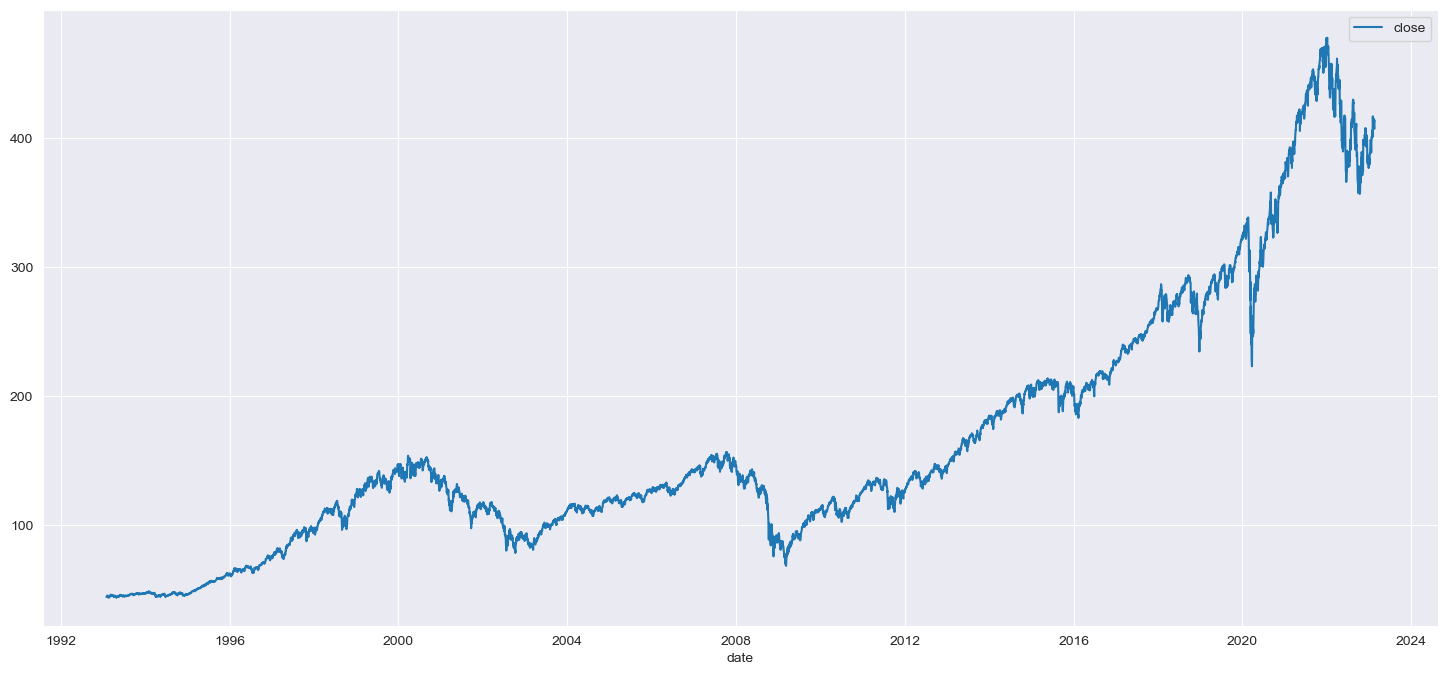

In [355]:
# Chart to visualize the closing price to note the general trend of the variable.
fig, ax = plt.subplots(figsize=(18, 8))
sns.set_style("darkgrid")
sns.lineplot(data=df_fund, ax=ax)
plt.show()

### US Economic Indicators (Historical)
<div style="text-align:justify">The data on US economic indicators are in a monthly frequency and the dates of records range from 1981 to 2021. Monthly records are dated on the 1st of every month, regardless of weekend or bank holidays, which we will need to take note of when we join the two sets of data using date at the common key later. There are some null values for 2 indicators, <i>"Real Broad Effective Exchange Rate"</i> & <i>"Total Construction Spending"</i>, which probably is because these two indicators are only reported later. Like the data for the fund prices, we can see that there is a big movement in values in the year after the Covid pandemic started for most indicators. The scale of the variables vary quite widely as well, but since we will be running a regression model, there is no need to scale the variables. However, scaling of the features was performed here purely just so we may visualize the boxplots for all features at the same time.</div>

<table align='left'>
    <tr><td colspan='2' style="font-size:medium;font-weight:300"><b>Glossary</b></td></tr>
    <tr><td>unrate</td><td>Unemployment Rate</td></tr>
    <tr><td>psr</td><td>Personal Saving Rate</td></tr>
    <tr><td>m2</td><td>Measure of the money supply that includes cash, checking deposits, and other types of deposits that are readily convertible to cash such as CDs.</td></tr>
    <tr><td>dspic</td><td>Real Disposable Personal Income</td></tr>
    <tr><td>pce</td><td>Personal Consumption Expenditures</td></tr>
    <tr><td>reer</td><td>Real Broad Effective Exchange Rate</td></tr>
    <tr><td>ir</td><td>Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity</td></tr>
    <tr><td>ffer</td><td>Federal Funds Effective Rate</td></tr>
    <tr><td>tcs</td><td>Total Construction Spending</td></tr>
    <tr><td>indpro</td><td>Industrial Production Index</td></tr>
    <tr><td>ccpi</td><td>Composite Consumer Price Index</td></tr>
</table>
<br/>

In [356]:
# Loading historical data for US economic indicators.
df_econ = pd.read_csv('./data/econ-indicators-mthly.csv', header=0)
df_econ.head()

,DATE,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,1981-01-01,7.5,10.9,1612.900,4980.4,1870.0,NaN,12.568571,19.084516,NaN,51.1668,85.4
1,1981-02-01,7.4,10.8,1608.125,4965.0,1884.2,NaN,13.194444,15.934286,NaN,50.9509,85.9
2,1981-03-01,7.4,10.8,1629.400,4979.0,1902.9,NaN,13.115909,14.703871,NaN,51.2066,86.4
3,1981-04-01,7.2,10.9,1665.575,4965.1,1904.4,NaN,13.679524,15.719000,NaN,50.9711,87.0
4,1981-05-01,7.5,11.0,1655.150,4974.8,1913.8,NaN,14.099500,18.517742,NaN,51.2645,87.8


In [357]:
# Initial high-level look at the data summary to see if data needs cleansing or pre-processing before analysis.
df_econ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    490 non-null    object 
 1   unrate  490 non-null    float64
 2   psr     490 non-null    float64
 3   m2      490 non-null    float64
 4   dspic   490 non-null    float64
 5   pce     490 non-null    float64
 6   reer    334 non-null    float64
 7   ir      490 non-null    float64
 8   ffer    490 non-null    float64
 9   tcs     346 non-null    float64
 10  indpro  490 non-null    float64
 11  ccpi    490 non-null    float64
dtypes: float64(11), object(1)
memory usage: 46.1+ KB


In [358]:
# Changing date column to datetime datatype.
df_econ["DATE"] = pd.to_datetime(df_econ.DATE, format="%Y-%m-%d")
df_econ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    490 non-null    datetime64[ns]
 1   unrate  490 non-null    float64       
 2   psr     490 non-null    float64       
 3   m2      490 non-null    float64       
 4   dspic   490 non-null    float64       
 5   pce     490 non-null    float64       
 6   reer    334 non-null    float64       
 7   ir      490 non-null    float64       
 8   ffer    490 non-null    float64       
 9   tcs     346 non-null    float64       
 10  indpro  490 non-null    float64       
 11  ccpi    490 non-null    float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 46.1 KB


In [359]:
# Determining the date range of data, as well as the ranges for the two features with incomplete data.
print("[DATE] Min Date:{0:%Y-%m-%d}, Max Date:{1:%Y-%m-%d}".format(df_econ["DATE"].min(),df_econ["DATE"].max()))
print("[reer] Min Date:{0:%Y-%m-%d}, Max Date:{1:%Y-%m-%d}".format(df_econ[df_econ["reer"].notnull()]["DATE"].min(),df_econ[df_econ["reer"].notnull()]["DATE"].max()))
print("[tcs] Min Date:{0:%Y-%m-%d}, Max Date:{1:%Y-%m-%d}".format(df_econ[df_econ["tcs"].notnull()]["DATE"].min(),df_econ[df_econ["tcs"].notnull()]["DATE"].max()))

[DATE] Min Date:1981-01-01, Max Date:2021-10-01
[reer] Min Date:1994-01-01, Max Date:2021-10-01
[tcs] Min Date:1993-01-01, Max Date:2021-10-01


In [360]:
# A look at the description of the data for each feature
df_econ.describe()

,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
count,490.000000,490.000000,490.000000,490.000000,490.000000,334.000000,490.000000,490.000000,3.460000e+02,490.000000,490.000000
mean,6.210612,7.487959,6737.572622,9743.822653,7520.984082,109.907605,5.678053,4.257924,9.551016e+05,81.594382,182.975094
std,1.775719,3.025157,4554.832251,3122.829102,3967.478105,8.971247,3.308813,3.829564,2.827476e+05,18.303353,52.567796
min,3.500000,2.100000,1608.125000,4965.000000,1870.000000,93.060000,0.623636,0.049000,4.580800e+05,47.071200,85.400000
25%,4.900000,5.900000,3324.031250,6861.025000,3908.575000,102.042500,2.874762,0.922903,7.767380e+05,62.426675,140.600000
50%,5.700000,7.200000,5162.415000,9715.600000,7029.900000,111.100000,5.100902,3.991113,8.997035e+05,89.430800,185.650000
75%,7.300000,8.600000,9390.730000,12115.900000,10745.625000,116.485000,7.623068,6.264173,1.159758e+06,98.288025,225.701000
max,14.800000,33.800000,21152.350000,19119.500000,16290.700000,129.030000,15.323810,19.099667,1.598020e+06,104.165900,281.695000


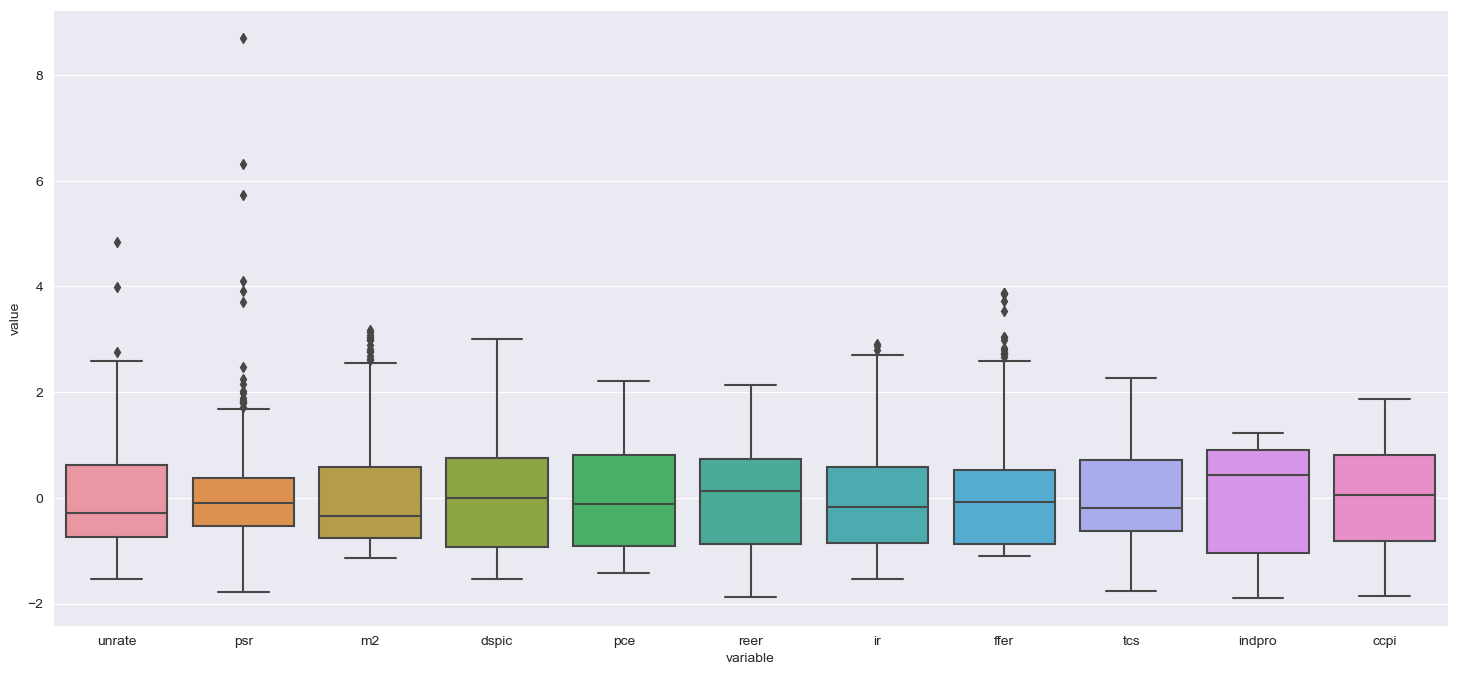

In [361]:
# For easier visualization, scaling of the features before a boxplot to better understand the characteristics of the data on hand.
df_econ_scaled = df_econ.drop(['DATE'], axis=1)
scaled_features = StandardScaler().fit_transform(df_econ_scaled)
df_boxplot = pd.DataFrame(scaled_features, index=df_econ_scaled.index, columns=df_econ_scaled.columns)
df_boxplot = pd.melt(df_boxplot)
fig, ax = plt.subplots(figsize=(18, 8))
sns.set_style('darkgrid')
sns.boxplot(x='variable', y='value', data=df_boxplot, ax=ax)
plt.show()

In [362]:
# A look at the loaded data for economic indicators.
df_econ = pd.read_csv('./data/econ-indicators-mthly.csv', header=0)
df_econ = df_econ.rename(columns={'DATE': 'date'})
df_econ["date"] = pd.to_datetime(df_econ.date, format="%Y-%m-%d")
df_econ.set_index("date", inplace=True, drop=True)
df_econ.head()

,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
date,,,,,,,,,,,
1981-01-01,7.5,10.9,1612.900,4980.4,1870.0,NaN,12.568571,19.084516,NaN,51.1668,85.4
1981-02-01,7.4,10.8,1608.125,4965.0,1884.2,NaN,13.194444,15.934286,NaN,50.9509,85.9
1981-03-01,7.4,10.8,1629.400,4979.0,1902.9,NaN,13.115909,14.703871,NaN,51.2066,86.4
1981-04-01,7.2,10.9,1665.575,4965.1,1904.4,NaN,13.679524,15.719000,NaN,50.9711,87.0
1981-05-01,7.5,11.0,1655.150,4974.8,1913.8,NaN,14.099500,18.517742,NaN,51.2645,87.8


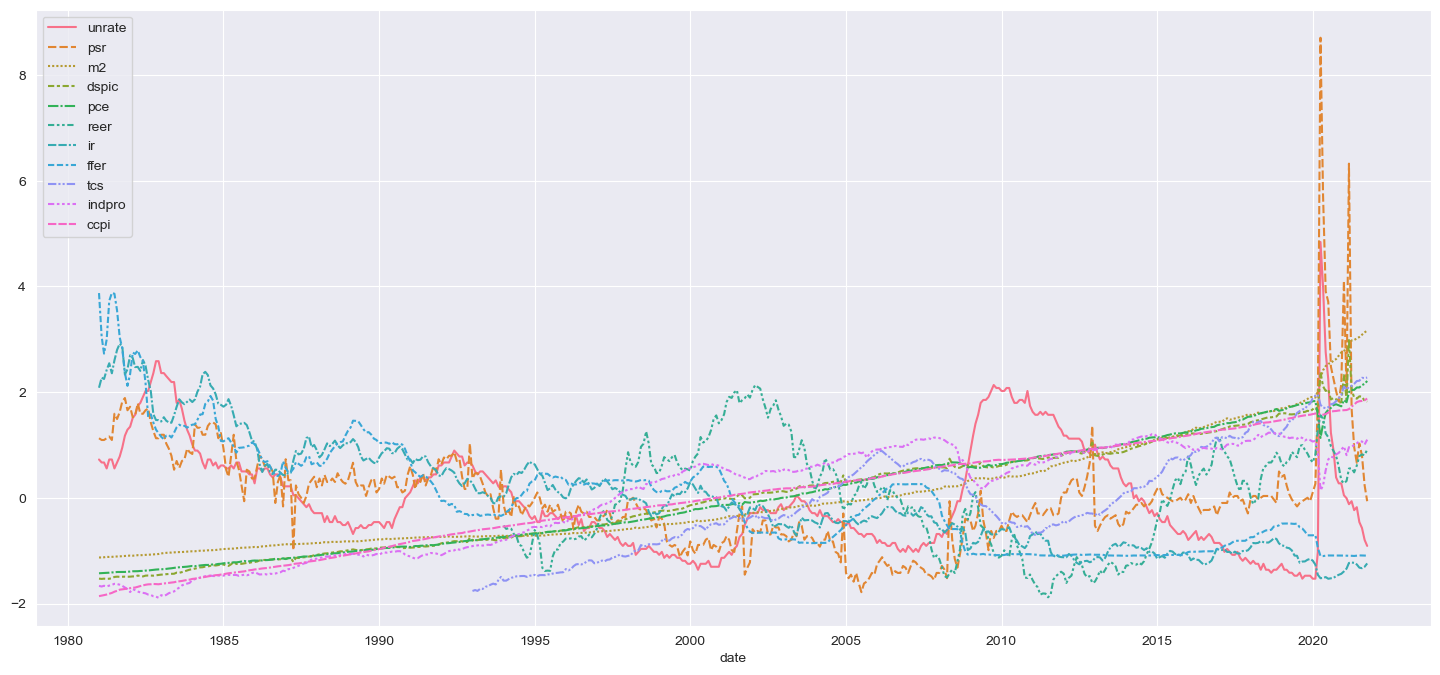

In [363]:
# For easier visualization across features, data is scaled and plotted on a line graph to identify trends.
scaled_features = StandardScaler().fit_transform(df_econ)
df_lineplot = pd.DataFrame(scaled_features, index=df_econ.index, columns=df_econ.columns)
fig, ax = plt.subplots(figsize=(18, 8))
sns.set_style("darkgrid")
sns.lineplot(data=df_lineplot, ax=ax)
plt.show()

## Feature Engineering
<div style="text-align:justify">Here we join the two sets of data using date of the record as the joining key. Because the fund price dataset does not contain all dates, we will change the date of the earliest record of the month to the first day of that month. We will also drop rows with empty values.</div>

In [364]:
# Reloading the historical data for both the selected fuind and US economic indicators, then joining them into a single dataframe.
df_fund = pd.read_csv('./data/hist_close_{0}.csv'.format(fund_sym.upper()), header=0)
df_fund = df_fund[["Date","Close"]]
df_fund = df_fund.rename(columns={"Date": "date", "Close": "close"})
df_fund["date"] = pd.to_datetime(df_fund.date, format="%Y-%m-%d")
df_fund.set_index("date", inplace=True, drop=True)

df_fund = df_fund.reset_index()
df_fund = df_fund.groupby(pd.Grouper(key='date', freq='MS')).agg({'date': 'first', 'close': 'first'})
df_fund = df_fund.drop("date", axis=1)

df_econ = pd.read_csv('./data/econ-indicators-mthly.csv', header=0)
df_econ = df_econ.rename(columns={'DATE': 'date'})
df_econ["date"] = pd.to_datetime(df_econ.date, format="%Y-%m-%d")
df_econ.set_index("date", inplace=True, drop=True)

df_econ_fund = pd.merge(df_econ, df_fund, on='date', how='inner')
df_econ_fund.head()

,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi,close
date,,,,,,,,,,,,
1993-01-01,7.3,8.6,3434.275,7237.6,4340.7,NaN,6.600000,3.024194,458080.0,64.9199,150.1,43.93750
1993-02-01,7.1,8.9,3398.625,7271.8,4355.3,NaN,6.258947,3.027143,462967.0,65.2156,150.6,44.25000
1993-03-01,7.0,8.9,3407.420,7249.2,4352.5,NaN,5.975217,3.074194,458399.0,65.1605,150.8,44.28125
1993-04-01,7.1,8.7,3433.100,7286.8,4393.4,NaN,5.969524,2.957667,469425.0,65.3503,151.4,45.03125
1993-05-01,7.1,8.3,3422.300,7276.3,4422.4,NaN,6.035500,2.996129,468998.0,65.0993,151.8,44.31250


In [365]:
# A high-level look at the merged data, rows reduced after an inner join between the monthly US economic indicators data and the daily fund prices data. There are still some rows without reer data after the inner join.
df_econ_fund.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 346 entries, 1993-01-01 to 2021-10-01
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   unrate  346 non-null    float64
 1   psr     346 non-null    float64
 2   m2      346 non-null    float64
 3   dspic   346 non-null    float64
 4   pce     346 non-null    float64
 5   reer    334 non-null    float64
 6   ir      346 non-null    float64
 7   ffer    346 non-null    float64
 8   tcs     346 non-null    float64
 9   indpro  346 non-null    float64
 10  ccpi    346 non-null    float64
 11  close   346 non-null    float64
dtypes: float64(12)
memory usage: 35.1 KB


In [366]:
# Dropping rows without reer data.
df_econ_fund = df_econ_fund[df_econ_fund['reer'].isnull() == False]
df_econ_fund.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1994-01-01 to 2021-10-01
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   unrate  334 non-null    float64
 1   psr     334 non-null    float64
 2   m2      334 non-null    float64
 3   dspic   334 non-null    float64
 4   pce     334 non-null    float64
 5   reer    334 non-null    float64
 6   ir      334 non-null    float64
 7   ffer    334 non-null    float64
 8   tcs     334 non-null    float64
 9   indpro  334 non-null    float64
 10  ccpi    334 non-null    float64
 11  close   334 non-null    float64
dtypes: float64(12)
memory usage: 33.9 KB


In [367]:
# Finding the date range of the data that used for analysis.
print("Min Date:{0:%Y-%m-%d}, Max Date:{1:%Y-%m-%d}".format(df_econ_fund.index.min(),df_econ_fund.index.max()))

Min Date:1994-01-01, Max Date:2021-10-01


## Feature Selection

### Pearson Correlation Coefficient
<div style="text-align:justify">Now that we have all the data we need in a single dataframe, we shall start identifying the relevant features to the fund price by comparing the Pearson Correlation Coefficient. As expected, most of the indicators are highly correlated with the fund price. For this study, we will pick the features with correlation magnitude larger than 0.7 (including negative correlation of -0.7) for our regression model. We then validate the selection using SelectKBest function. Surprisingly, the best 6 features selected by SelectKBest are different depending on the choice of scoring function.</div>

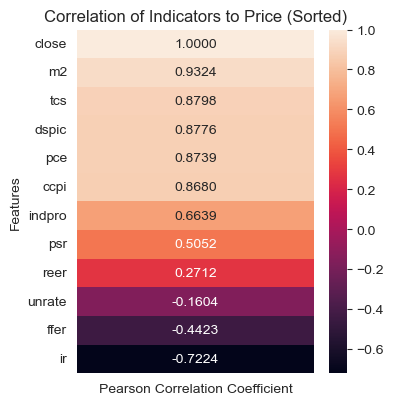

In [368]:
# Finding the Pearson correlation coefficient of features with the target variable (closing price).
# Selecting features by Pearson correlation coefficient (>=0.7 or <=-0.7): ['m2','tcs','dspic','pce','ccpi','ir']
fund_price_corr = pd.DataFrame()
fund_price_corr["Features"] = df_econ_fund.corr()["close"].keys()
fund_price_corr["Pearson Correlation Coefficient"] = df_econ_fund.corr()["close"].values
fund_price_corr.set_index("Features", inplace=True)
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(fund_price_corr.sort_values(by=["Pearson Correlation Coefficient"], ascending=False), annot=True, fmt=".4f")
ax.xaxis.set_label_position("bottom")
ax.yaxis.set_label_position("left")
plt.tight_layout()
plt.title("Correlation of Indicators to Price (Sorted)")
plt.show()    

In [369]:
# Validating feature selection with SelectKBest (f_regression)
X, y = prep_data(fund_sym)
X_best_6_freg = best_k_features(f_regression, 6, X, y)
X_best_6_freg.head()

,m2,dspic,pce,ir,tcs,ccpi
date,,,,,,
1994-02-01,3459.675,7377.2,4632.6,5.973158,513196.0,154.8
1994-03-01,3476.975,7401.7,4646.0,6.482609,521040.0,155.3
1994-06-01,3478.875,7475.5,4708.9,7.101364,536198.0,156.4
1994-07-01,3492.175,7481.7,4720.6,7.298000,537232.0,156.7
1994-08-01,3481.500,7490.5,4762.6,7.236087,537960.0,157.1


In [370]:
# Validating feature selection with SelectKBest (mutual_info_regression)
X, y = prep_data(fund_sym)
X_best_6_mireg = best_k_features(mutual_info_regression, 6, X, y)
X_best_6_mireg.head()

,m2,dspic,pce,tcs,indpro,ccpi
date,,,,,,
1994-02-01,3459.675,7377.2,4632.6,513196.0,67.1060,154.8
1994-03-01,3476.975,7401.7,4646.0,521040.0,67.7792,155.3
1994-06-01,3478.875,7475.5,4708.9,536198.0,68.9608,156.4
1994-07-01,3492.175,7481.7,4720.6,537232.0,69.0536,156.7
1994-08-01,3481.500,7490.5,4762.6,537960.0,69.5074,157.1


### Feature Combinations - MSE & R2 Comparison
<div style="text-align:justify">The Pearson Correlation Coefficient only indicates the correlation strength between a feature and the target variable. When these features combine, the correlation between a set of combined features and the target variable is usually different. To get a clue on how different combinations of features correlate with the target variable, we leverage statsmodel to run through all possible combinations of features through linear regression and observe the MSE values. Surprisingly, the best performing feature combination is the one where all 11 features are included, where MSE model is not too low risking overfitting, MSE residuals is kept low indicating the accuracy of predictions and a high R2 at 0.98 showing a good fit of the data.</div>

In [371]:
# Preparing to model the data with different combinations of features to find MSE and R2.
all_features = df_econ_fund.columns.values.tolist()
all_features = [e for e in all_features if e not in ('close')]
feature_combos = list(powerset(all_features))
print('Total Combinations:', len(feature_combos))

Total Combinations: 2048


In [372]:
# Running the different combinations of features to find the MSE and R2 values. 
# Selecting the feature combination with lowest total MSE and highest R2: ['unrate','psr','m2','dspic','pce','reer','ir','ffer','tcs','indpro','ccpi'] (all 11 features)
list_case, list_features, list_formula, list_rsquared, list_mse_mod, list_mse_res  = [],[],[],[],[],[]
case_count = 0

for combo in tqdm(feature_combos):
    combo_filtered = list(filter(None,combo))
    if len(combo_filtered) == 0:
        continue
    case_count += 1
    f = ''
    for feature in combo_filtered:
        if len(f) == 0:
            f += 'close ~ ' + feature
        else:
            f += ' + ' + feature
    
    case_id = 'case_i_' + str(case_count).zfill(5)
    model = smf.ols(formula=f, data=df_econ_fund)
    result = model.fit()    
    
    list_case.append(case_id)
    list_features.append(combo_filtered)
    list_formula.append(f)    
    list_mse_mod.append(result.mse_model)
    list_mse_res.append(result.mse_resid)
    list_rsquared.append(result.rsquared_adj)
    
df_stat = pd.DataFrame({'Case': list_case,
                       'Features': list_features,
                       'Formula': list_formula,
                       'MSE Model': list_mse_mod,
                       'MSE Residuals': list_mse_res,
                       'MSE Total': [x+y for x,y in zip(list_mse_mod,list_mse_res)],
                       'R2 Adjusted': list_rsquared})
df_stat.sort_values(by=['MSE Total'], ascending=True).head(10)

100%|█████████████████████████████████████████████████████████████████████████████| 2048/2048 [00:13<00:00, 153.35it/s]


,Case,Features,Formula,MSE Model,MSE Residuals,MSE Total,R2 Adjusted
0,case_i_00001,[unrate],close ~ unrate,58015.127277,6619.092075,64634.219352,0.022786
15,case_i_00016,"[unrate, reer]",close ~ unrate + reer,84558.011603,6303.437079,90861.448681,0.069388
5,case_i_00006,[reer],close ~ reer,165872.088979,6294.221709,172166.310688,0.070749
2046,case_i_02047,"[unrate, psr, m2, dspic, pce, reer, ir, ffer, tcs, indpro, ccpi]",close ~ unrate + psr + m2 + dspic + pce + reer + ir + ffer + tcs + indpro + ccpi,201289.876685,128.462896,201418.339582,0.981034
2043,case_i_02044,"[unrate, psr, dspic, pce, reer, ir, ffer, tcs, indpro, ccpi]",close ~ unrate + psr + dspic + pce + reer + ir + ffer + tcs + indpro + ccpi,213305.807798,379.243400,213685.051198,0.944010
2036,case_i_02037,"[unrate, psr, m2, dspic, pce, reer, ir, ffer, tcs, ccpi]",close ~ unrate + psr + m2 + dspic + pce + reer + ir + ffer + tcs + ccpi,220170.300673,166.720401,220337.021074,0.975386
2038,case_i_02039,"[unrate, psr, m2, dspic, pce, reer, ir, tcs, indpro, ccpi]",close ~ unrate + psr + m2 + dspic + pce + reer + ir + tcs + indpro + ccpi,220528.345555,155.635420,220683.980975,0.977023
2040,case_i_02041,"[unrate, psr, m2, dspic, pce, ir, ffer, tcs, indpro, ccpi]",close ~ unrate + psr + m2 + dspic + pce + ir + ffer + tcs + indpro + ccpi,221015.415010,140.555870,221155.970880,0.979249
2039,case_i_02040,"[unrate, psr, m2, dspic, pce, reer, ffer, tcs, indpro, ccpi]",close ~ unrate + psr + m2 + dspic + pce + reer + ffer + tcs + indpro + ccpi,221037.656965,139.867265,221177.524230,0.979351
2037,case_i_02038,"[unrate, psr, m2, dspic, pce, reer, ir, ffer, indpro, ccpi]",close ~ unrate + psr + m2 + dspic + pce + reer + ir + ffer + indpro + ccpi,221136.824300,136.797069,221273.621369,0.979804


## Data Modeling

In [373]:
# Initialise common info for analysis
X, y = prep_data(fund_sym)
X_best_6_freg = best_k_features(f_regression, 6, X, y)
X_best_6_mireg = best_k_features(mutual_info_regression, 6, X, y)
rkf = RepeatedKFold(n_splits=5, n_repeats=10)

### Linear Regression
<div style="text-align:justify">We first run the 6 selected features and later all features through vanilla linear regression. The best performing model is the one which includes all economic indicators.</div>

In [374]:
# Linear Regression - Best 6 Features by F-Regression

# Performance Tracking
dt_start = start_timing()

# Initialise Data & Parameters
X = X_best_6_freg
mae_scores, mse_scores, rmse_scores = [],[],[]

# Loop over the folds and repetitions
for train_index, test_index in tqdm(rkf.split(X)):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Fit a linear regression model to the training data
    model = LinearRegression()
    model.fit(X_train, y_train)
    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    # Add the mean squared error to the list
    mae_scores.append(metrics.mean_absolute_error(y_test, y_pred))
    mse_scores.append(metrics.mean_squared_error(y_test, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_test, y_pred, squared=False))

print('Linear Regression (Best 6 Features by F-Reg) - Mean MAE = {0:0.4f}'.format(np.mean(mae_scores)))
print('Linear Regression (Best 6 Features by F-Reg) - Mean MSE = {0:0.4f}'.format(np.mean(mse_scores)))
print('Linear Regression (Best 6 Features by F-Reg) - Mean RMSE = {0:0.4f}'.format(np.mean(rmse_scores)))

# Performance Tracking
show_duration(dt_start)


Start: 2023-04-21 05:44:55.930459


50it [00:00, 208.87it/s]

Linear Regression (Best 6 Features by F-Reg) - Mean MAE = 16.6080
Linear Regression (Best 6 Features by F-Reg) - Mean MSE = 464.7902
Linear Regression (Best 6 Features by F-Reg) - Mean RMSE = 21.4851
Duration: 0:00:00.249866


In [375]:
# Linear Regression - Best 6 Features by Mutual Info Regression

# Performance Tracking
dt_start = start_timing()

# Initialise Data & Parameters
X = X_best_6_mireg
mae_scores, mse_scores, rmse_scores = [],[],[]

# Loop over the folds and repetitions
for train_index, test_index in tqdm(rkf.split(X)):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Fit a linear regression model to the training data
    model = LinearRegression()
    model.fit(X_train, y_train)
    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    # Add the mean squared error to the list
    mae_scores.append(metrics.mean_absolute_error(y_test, y_pred))
    mse_scores.append(metrics.mean_squared_error(y_test, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_test, y_pred, squared=False))

print('Linear Regression (Best 6 Features by Mutual Info Reg) - Mean MAE = {0:0.4f}'.format(np.mean(mae_scores)))
print('Linear Regression (Best 6 Features by Mutual Info Reg) - Mean MSE = {0:0.4f}'.format(np.mean(mse_scores)))
print('Linear Regression (Best 6 Features by Mutual Info Reg) - Mean RMSE = {0:0.4f}'.format(np.mean(rmse_scores)))

# Performance Tracking
show_duration(dt_start)


Start: 2023-04-21 05:44:56.195285


50it [00:00, 207.95it/s]

Linear Regression (Best 6 Features by Mutual Info Reg) - Mean MAE = 14.4940
Linear Regression (Best 6 Features by Mutual Info Reg) - Mean MSE = 293.5170
Linear Regression (Best 6 Features by Mutual Info Reg) - Mean RMSE = 17.0613
Duration: 0:00:00.243689


In [376]:
# Linear Regression - All Features

# Performance Tracking
dt_start = start_timing()

# Initialise Data & Parameters
X, y =prep_data(fund_sym)
mae_scores, mse_scores, rmse_scores = [],[],[]

# Loop over the folds and repetitions
for train_index, test_index in tqdm(rkf.split(X)):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Fit a linear regression model to the training data
    model = LinearRegression()
    model.fit(X_train, y_train)
    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    # Add the mean squared error to the list
    mae_scores.append(metrics.mean_absolute_error(y_test, y_pred))
    mse_scores.append(metrics.mean_squared_error(y_test, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_test, y_pred, squared=False))

print('Linear Regression (All Features) - Mean MAE = {0:0.4f}'.format(np.mean(mae_scores)))
print('Linear Regression (All Features) - Mean MSE = {0:0.4f}'.format(np.mean(mse_scores)))
print('Linear Regression (All Features) - Mean RMSE = {0:0.4f}'.format(np.mean(rmse_scores)))

# Performance Tracking
show_duration(dt_start)


Start: 2023-04-21 05:44:56.460917


50it [00:00, 208.00it/s]

Linear Regression (All Features) - Mean MAE = 8.4443
Linear Regression (All Features) - Mean MSE = 115.5221
Linear Regression (All Features) - Mean RMSE = 10.6901
Duration: 0:00:00.272300


### Ridge Regression
<div style="text-align:justify">Considering that some of the economic indicators might have a high correlation with one another, we try running the data through ridge regression here to see if our model accuracy can be improved. Turns out the results are about the same with vanilla linear regression.</div>

In [377]:
# Ridge Regression - Best 6 Features by F-Regression

# Performance Tracking
dt_start = start_timing()

# Initialise Data & Parameters
X = X_best_6_freg
mae_scores, mse_scores, rmse_scores = [],[],[]

# Loop over the folds and repetitions
for train_index, test_index in tqdm(rkf.split(X)):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Fit a ridge regression model to the training data
    model = Ridge(alpha=1.0, fit_intercept=True, max_iter=100000)
    model.fit(X_train, y_train)
    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    # Add the mean squared error to the list
    mae_scores.append(metrics.mean_absolute_error(y_test, y_pred))
    mse_scores.append(metrics.mean_squared_error(y_test, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_test, y_pred, squared=False))

print('Ridge Regression (Best 6 Features by F-Reg) - Mean MAE = {0:0.4f}'.format(np.mean(mae_scores)))
print('Ridge Regression (Best 6 Features by F-Reg) - Mean MSE = {0:0.4f}'.format(np.mean(mse_scores)))
print('Ridge Regression (Best 6 Features by F-Reg) - Mean RMSE = {0:0.4f}'.format(np.mean(rmse_scores)))

# Performance Tracking
show_duration(dt_start)


Start: 2023-04-21 05:44:56.741706


50it [00:00, 212.38it/s]

Ridge Regression (Best 6 Features by F-Reg) - Mean MAE = 16.7563
Ridge Regression (Best 6 Features by F-Reg) - Mean MSE = 478.9905
Ridge Regression (Best 6 Features by F-Reg) - Mean RMSE = 21.7557
Duration: 0:00:00.239084


In [378]:
# Ridge Regression - Best 6 Features by Mutual Information Regression

# Performance Tracking
dt_start = start_timing()

# Initialise Data & Parameters
X = X_best_6_mireg
mae_scores, mse_scores, rmse_scores = [],[],[]

# Loop over the folds and repetitions
for train_index, test_index in tqdm(rkf.split(X)):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Fit a ridge regression model to the training data
    model = Ridge(alpha=1.0, fit_intercept=True, max_iter=100000)
    model.fit(X_train, y_train)
    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    # Add the mean squared error to the list
    mae_scores.append(metrics.mean_absolute_error(y_test, y_pred))
    mse_scores.append(metrics.mean_squared_error(y_test, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_test, y_pred, squared=False))

print('Ridge Regression (Best 6 Features by Mutual Info Reg) - Mean MAE = {0:0.4f}'.format(np.mean(mae_scores)))
print('Ridge Regression (Best 6 Features by Mutual Info Reg) - Mean MSE = {0:0.4f}'.format(np.mean(mse_scores)))
print('Ridge Regression (Best 6 Features by Mutual Info Reg) - Mean RMSE = {0:0.4f}'.format(np.mean(rmse_scores)))

# Performance Tracking
show_duration(dt_start)


Start: 2023-04-21 05:44:56.993756


50it [00:00, 229.27it/s]

Ridge Regression (Best 6 Features by Mutual Info Reg) - Mean MAE = 14.4715
Ridge Regression (Best 6 Features by Mutual Info Reg) - Mean MSE = 294.8557
Ridge Regression (Best 6 Features by Mutual Info Reg) - Mean RMSE = 17.1021
Duration: 0:00:00.221278


In [379]:
# Ridge Regression - All Features

# Performance Tracking
dt_start = start_timing()

# Initialise Data & Parameters
X, y = prep_data(fund_sym)
mae_scores, mse_scores, rmse_scores = [],[],[]

# Loop over the folds and repetitions
for train_index, test_index in tqdm(rkf.split(X)):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Fit a ridge regression model to the training data
    model = Ridge(alpha=1.0, fit_intercept=True, max_iter=100000)
    model.fit(X_train, y_train)
    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    # Add the mean squared error to the list
    mae_scores.append(metrics.mean_absolute_error(y_test, y_pred))
    mse_scores.append(metrics.mean_squared_error(y_test, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_test, y_pred, squared=False))

print('Ridge Regression (All Features) - Mean MAE = {0:0.4f}'.format(np.mean(mae_scores)))
print('Ridge Regression (All Features) - Mean MSE = {0:0.4f}'.format(np.mean(mse_scores)))
print('Ridge Regression (All Features) - Mean RMSE = {0:0.4f}'.format(np.mean(rmse_scores)))

# Performance Tracking
show_duration(dt_start)


Start: 2023-04-21 05:44:57.227016


50it [00:00, 210.63it/s]

Ridge Regression (All Features) - Mean MAE = 8.4871
Ridge Regression (All Features) - Mean MSE = 116.0305
Ridge Regression (All Features) - Mean RMSE = 10.7229
Duration: 0:00:00.266528


## Hyperparameter Tuning

### Ridge Regression
<div style="text-align:justify">Vanilla linear regression does not have many parameters that we can tune so here we try it with ridge regression. GridSearchCV is used for hyperparameter tuning. Results unfortunately did not improve significantly over the pre-tuning model.</div>

In [380]:
# GridSearchCV Parameters
alphas = [0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
solvers = ['auto','svd','cholesky','lsqr','sparse_cg','sag','saga','lbfgs']
boo = [True, False]
rkf = RepeatedKFold(n_splits=5, n_repeats=10)
scoring = 'neg_mean_squared_error' # ['neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error','r2']

In [381]:
# Ridge Regression, GridSearchCV Hyperparameter Tuning

# Setup parameters
model = Ridge(fit_intercept=True, max_iter=500000)
gs_params = {'alpha': alphas,
             'solver': solvers,
             'positive': boo}

# Prep data
X, y = prep_data(fund_sym)

# Run GridSearchCV
dt_start = start_timing()
gs = GridSearchCV(estimator = model,  
                  param_grid = gs_params,
                  scoring = scoring,
                  cv = rkf,
                  verbose = 1,
                  n_jobs = 10)
gs.fit(X, y.values.ravel())
show_duration(dt_start)

# Show Results
df_cv_results = pd.DataFrame(gs.cv_results_)
df_cv_results.head()


Start: 2023-04-21 05:44:57.557918
Fitting 50 folds for each of 208 candidates, totalling 10400 fits
Duration: 0:00:09.200670


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_positive,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004478,0.000917,0.001905,0.000485,0.001,True,auto,"{'alpha': 0.001, 'positive': True, 'solver': 'auto'}",-839.292341,-761.218023,-912.437763,-794.389005,-694.759168,-804.303418,-639.665031,-938.646651,-785.180852,-678.618362,-1019.786605,-693.609935,-910.843515,-524.205548,-776.377902,-664.601865,-667.70714,-639.047392,-774.246974,-1164.737119,-773.958333,-870.188627,-696.22039,-925.573801,-605.229957,-554.920994,-765.04158,-1042.070467,-914.211939,-591.693275,-903.352251,-654.316697,-833.102791,-588.957036,-905.145415,-661.150654,-532.073244,-714.736659,-1038.351398,-940.367732,-715.958577,-815.830611,-823.485579,-597.091013,-903.395284,-861.322575,-760.879465,-748.771723,-704.146944,-790.865003,-778.321692,140.991271,53
1,0.002184,0.000590,0.000000,0.000000,0.001,True,svd,"{'alpha': 0.001, 'positive': True, 'solver': 'svd'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125
2,0.001556,0.000495,0.000000,0.000000,0.001,True,cholesky,"{'alpha': 0.001, 'positive': True, 'solver': 'cholesky'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127
3,0.001396,0.000489,0.000000,0.000000,0.001,True,lsqr,"{'alpha': 0.001, 'positive': True, 'solver': 'lsqr'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122
4,0.001716,0.000448,0.000000,0.000000,0.001,True,sparse_cg,"{'alpha': 0.001, 'positive': True, 'solver': 'sparse_cg'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124


In [382]:
# Show top parameter settings
df_cv_results[['param_alpha','param_solver','param_positive','mean_test_score','rank_test_score']].sort_values(by=['rank_test_score'], ascending=True).head()

,param_alpha,param_solver,param_positive,mean_test_score,rank_test_score
104,10,auto,False,-113.225751,1
106,10,cholesky,False,-113.225751,1
105,10,svd,False,-113.225751,3
90,5,cholesky,False,-113.468734,4
88,5,auto,False,-113.468734,4


In [389]:
# Ridge Regression - All Features, Post-Tuning

# Performance Tracking
dt_start = start_timing()

# Initialise Data & Parameters
X, y = prep_data(fund_sym)
mae_scores, mse_scores, rmse_scores = [],[],[]

# Loop over the folds and repetitions
for train_index, test_index in tqdm(rkf.split(X)):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Fit a ridge regression model to the training data
    model = Ridge(alpha=10, solver='cholesky', positive=False, fit_intercept=True, max_iter=500000)
    model.fit(X_train, y_train)
    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    # Add the mean squared error to the list
    mae_scores.append(metrics.mean_absolute_error(y_test, y_pred))
    mse_scores.append(metrics.mean_squared_error(y_test, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_test, y_pred, squared=False))

print('Ridge Regression (All Features, Post-Tuning) - Mean MAE = {0:0.4f}'.format(np.mean(mae_scores)))
print('Ridge Regression (All Features, Post-Tuning) - Mean MSE = {0:0.4f}'.format(np.mean(mse_scores)))
print('Ridge Regression (All Features, Post-Tuning) - Mean RMSE = {0:0.4f}'.format(np.mean(rmse_scores)))

# Performance Tracking
show_duration(dt_start)


Start: 2023-04-21 05:47:22.956007


50it [00:00, 189.53it/s]

Ridge Regression (All Features, Post-Tuning) - Mean MAE = 8.5071
Ridge Regression (All Features, Post-Tuning) - Mean MSE = 113.9777
Ridge Regression (All Features, Post-Tuning) - Mean RMSE = 10.5932
Duration: 0:00:00.290678


## Conclusion
<div style="text-align:justify">We can clearly see a correlation between economic indicators and the fund price. Considering that the fund price is currently at \$400+ and our model has an RMSE value of about 10.5, I think our predictive model is performing decently. This model however is untested with new data. We all know that due to the Covid pandemic, a lot of contributing factors to the economic indicators are out of the ordinary so there is a chance that our model will not work as well when tested against new data. I feel the model can be improved too, if we have the date on which the figure for each economic indicator is announced. The market reacts immediately, so having such data on hand will give us better insight on the nature of the correlation between economic indicators and fund price.</div>

## Changelog
<table align='left'>
    <tr><td><b>Date</b></td><td><b>Update/s</b></td></tr>
    <tr><td>21-Apr-23</td><td>Initial version.</td></tr>
</table>
<br/>